Load Required Libraries

In [40]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

Load and Inspect Data

In [41]:
df = pd.read_csv("dirty_cafe_sales.csv")

df.head(5)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2,4,Credit Card,Takeaway,9/8/2023
1,TXN_4977031,Cake,4,3,12,Cash,In-store,5/16/2023
2,TXN_4271903,Cookie,4,1,ERROR,Credit Card,In-store,7/19/2023
3,TXN_7034554,Salad,2,5,10,UNKNOWN,UNKNOWN,4/27/2023
4,TXN_3160411,Coffee,2,2,4,Digital Wallet,In-store,6/11/2023


View Column names, data types & non-null counts

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


Check summary statistics

In [43]:
df.describe()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_1961373,Juice,5,3,6,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


Check total nulls per column

In [44]:
df.isna().sum()

Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

Replace all placeholders with NaN

In [45]:
df.replace(["ERROR","UNKNOWN",""], np.nan, inplace = True)

Check total nulls after replacement

In [46]:
df.isna().sum()

Transaction ID         0
Item                 969
Quantity             479
Price Per Unit       533
Total Spent          502
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64

View affected rows

In [47]:
df[df.isna().any(axis=1)].head(10)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
2,TXN_4271903,Cookie,4,1,NaN,Credit Card,In-store,7/19/2023
3,TXN_7034554,Salad,2,5,10,NaN,NaN,4/27/2023
5,TXN_2602893,Smoothie,5,4,20,Credit Card,NaN,3/31/2023
6,TXN_4433211,NaN,3,3,9,NaN,Takeaway,10/6/2023
7,TXN_6699534,Sandwich,4,4,16,Cash,NaN,10/28/2023
8,TXN_4717867,NaN,5,3,15,NaN,Takeaway,7/28/2023
9,TXN_2064365,Sandwich,5,4,20,NaN,In-store,12/31/2023
11,TXN_3051279,Sandwich,2,4,8,Credit Card,Takeaway,NaN
13,TXN_9437049,Cookie,5,1,5,NaN,Takeaway,6/1/2023
14,TXN_8915701,NaN,2,1.5,3,NaN,In-store,3/21/2023


Convert all numeric columns to proper numeric columns

In [48]:
numeric_columns = ["Quantity","Price Per Unit","Total Spent"]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

Convert Transaction Date column to datetime

In [49]:
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors="coerce")

Confirm data types per column

In [50]:
df.dtypes

Transaction ID              object
Item                        object
Quantity                   float64
Price Per Unit             float64
Total Spent                float64
Payment Method              object
Location                    object
Transaction Date    datetime64[ns]
dtype: object

Check validty of Total Spent column & count total invalid entries

In [51]:
df['valid_total'] = np.isclose(df['Total Spent'], df['Quantity'] * df['Price Per Unit'], atol=0.01, equal_nan=False)


invalid_total_count = (~df['valid_total']).sum()
invalid_total_count

1456

Create placeholders list

In [52]:
placeholders = ["UNKNOWN", "ERROR", "", " ", None, np.nan]

Compute completeness per column

In [53]:
completeness = df.notna().mean() * 100
completeness = completeness.round(2)
completeness


Transaction ID      100.00
Item                 90.31
Quantity             95.21
Price Per Unit       94.67
Total Spent          94.98
Payment Method       68.22
Location             60.39
Transaction Date     95.40
valid_total         100.00
dtype: float64

Compute Validity per Column

In [54]:
validity = {}
for col in df.columns:
    validity[col] = (~df[col].isin(placeholders)).mean() * 100

validity = pd.Series(validity).round(2)
validity

Transaction ID      100.00
Item                 90.31
Quantity             95.21
Price Per Unit       94.67
Total Spent          94.98
Payment Method       68.22
Location             60.39
Transaction Date    100.00
valid_total         100.00
dtype: float64

Compute Accuracy Score

In [55]:
accuracy_score = df["valid_total"].mean() * 100
accuracy_score = round(accuracy_score, 2)
accuracy_score

85.44

Compute Uniqueness Score

In [56]:
duplicates = df.duplicated().mean() * 100
unique_score = 100 - duplicates

print("Duplicate Rows (%):", duplicates)
print("Uniqueness Score (%):", unique_score)

Duplicate Rows (%): 0.0
Uniqueness Score (%): 100.0


Check for Consistency (Transaction ID Format)

In [57]:
id_pattern = r"^TXN_\d{7}$"

# Check if each Transaction ID matches the pattern
df["Transaction_ID_Valid"] = df["Transaction ID"].apply(
    lambda x: bool(re.match(id_pattern, str(x)))
)

# Optional: see invalid IDs
invalid_ids = df[~df["Transaction_ID_Valid"]]

# Compute overall consistency score (0-100%)
consistency_score = df["Transaction_ID_Valid"].mean() * 100

print("Consistency Score (Transaction ID only):", consistency_score)
print("\nInvalid Transaction IDs:")
print(invalid_ids[["Transaction ID"]])


Consistency Score (Transaction ID only): 100.0

Invalid Transaction IDs:
Empty DataFrame
Columns: [Transaction ID]
Index: []


Create score card & summary table for the quality metrics

In [58]:
scorecard = pd.DataFrame({
    "Completeness": completeness.mean().round(2),
    "Validity": validity.mean().round(2),
    "Accuracy": accuracy_score,
    "Uniqueness": unique_score,
    "Consistency": consistency_score
}, index=["DQ Score (%)"])


scorecard

,Completeness,Validity,Accuracy,Uniqueness,Consistency
DQ Score (%),88.8,89.31,85.44,100.0,100.0


In [59]:
dq_summary = pd.DataFrame({
    "Completeness (%)": completeness,
    "Validity (%)": validity
})


dq_summary

,Completeness (%),Validity (%)
Transaction ID,100.00,100.00
Item,90.31,90.31
Quantity,95.21,95.21
Price Per Unit,94.67,94.67
Total Spent,94.98,94.98
Payment Method,68.22,68.22
Location,60.39,60.39
Transaction Date,95.40,100.00
valid_total,100.00,100.00


Overall data quality score

In [60]:
dq_score = (
    completeness.mean() * 0.3 +
    validity.mean() * 0.3 +
    accuracy_score * 0.2 +
    consistency_score * 0.2
)
dq_score = round(dq_score, 2)
print(f"Overall Data Quality Score:{dq_score:.2f}%")

Overall Data Quality Score:90.52%


Create column that marks data errors (null values, placeholders & invalid totals)

In [61]:
df["has_error"] = (
    df.isna().any(axis=1) |                          
    df.isin(placeholders).any(axis=1) |              
    (~df["valid_total"])                             
)

In [62]:
error_rate = df["has_error"].mean() * 100
print(f"Overall Error Rate: {error_rate:.2f}%")

Overall Error Rate: 69.11%


Mean Error Rate per Location

In [63]:
error_by_location = df.groupby("Location")["has_error"].mean().sort_values(ascending=False) * 100
error_by_location

Location
In-store    48.889625
Takeaway    48.808736
Name: has_error, dtype: float64

Mean Error Rate per Payment Method

In [64]:
error_by_payment = df.groupby("Payment Method")["has_error"].mean().sort_values(ascending=False) * 100
error_by_payment

Payment Method
Credit Card       55.917290
Cash              54.915855
Digital Wallet    53.339153
Name: has_error, dtype: float64

In [65]:
error_by_item = df.groupby("Item")["has_error"].mean().sort_values(ascending=False) * 100
error_by_item

Item
Smoothie    69.160584
Coffee      68.497854
Cake        66.198420
Tea         65.840220
Sandwich    65.428824
Cookie      64.194139
Salad       63.588850
Juice       63.535440
Name: has_error, dtype: float64

Mean Error Rate per Location & Payment Method

In [66]:
error_cluster = (
    df.groupby(["Location", "Payment Method"])["has_error"]
    .mean()
    .reset_index()
    .sort_values("has_error", ascending=False)
)
error_cluster.head(10)

,Location,Payment Method,has_error
3,Takeaway,Cash,0.268072
2,In-store,Digital Wallet,0.266187
1,In-store,Credit Card,0.265786
4,Takeaway,Credit Card,0.249626
5,Takeaway,Digital Wallet,0.248656
0,In-store,Cash,0.242165


Set consistent style for the charts

In [67]:
sns.set(style="white", palette="deep")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.family"] = "sans-serif"


Plot Chart of Error by Payment Method

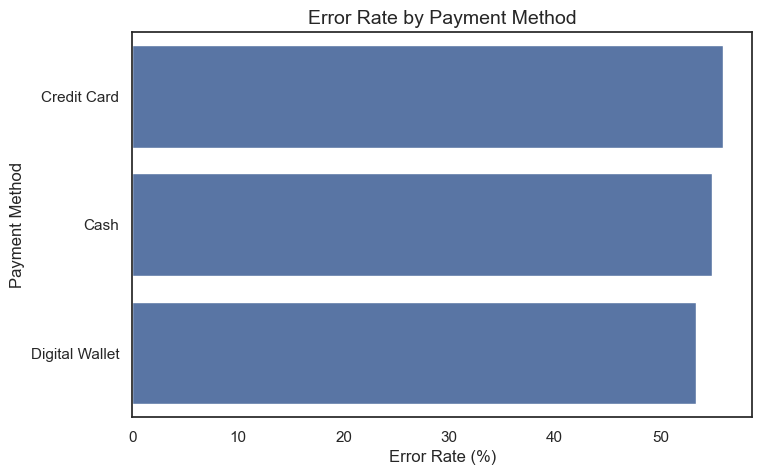

In [68]:
plt.figure()
sns.barplot(x=error_by_payment.values, y=error_by_payment.index)
plt.title("Error Rate by Payment Method", fontsize=14)
plt.xlabel("Error Rate (%)")
plt.ylabel("Payment Method")
plt.show()


Plot Chart of Error by Location

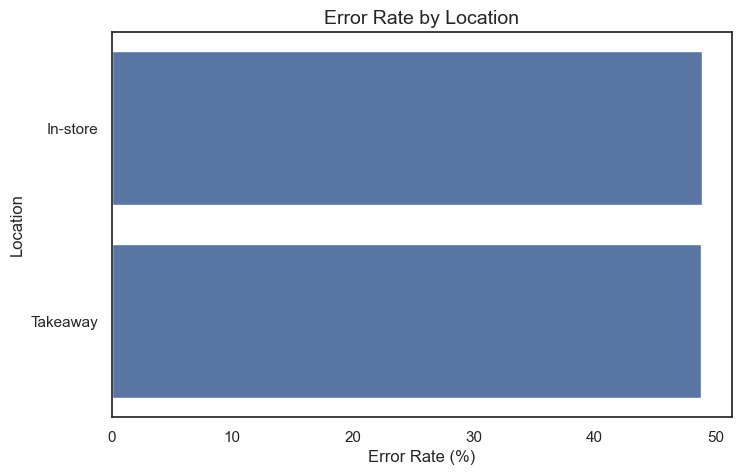

In [69]:
plt.figure()
sns.barplot(x=error_by_location.values, y=error_by_location.index)
plt.title("Error Rate by Location", fontsize=14)
plt.xlabel("Error Rate (%)")
plt.ylabel("Location")
plt.show()


Create pivot table for heatmap plot

In [70]:
error_pivot = df.pivot_table(values="has_error",
                             index="Location",
                             columns="Payment Method",
                             aggfunc="mean") * 100

error_pivot

Payment Method,Cash,Credit Card,Digital Wallet
Location,,,
In-store,24.216524,26.578561,26.618705
Takeaway,26.807229,24.962631,24.865591


Plot heatmap for Error Clusters

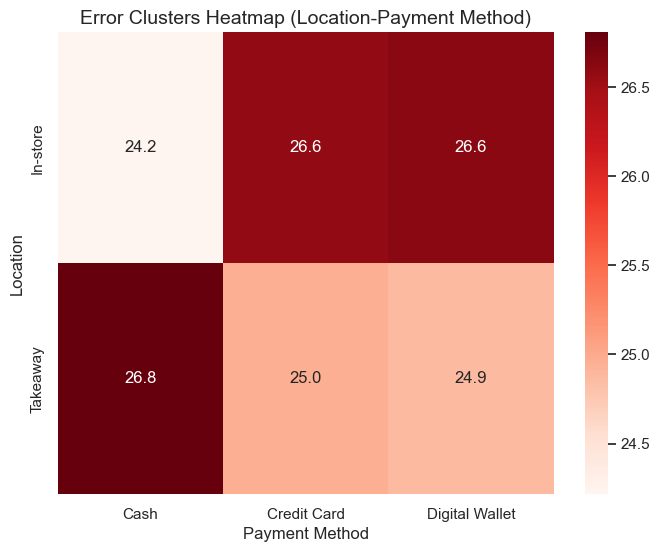

In [71]:
plt.figure(figsize=(8,6))
sns.heatmap(error_pivot, annot=True, fmt=".1f", cmap="Reds")
plt.title("Error Clusters Heatmap (Location-Payment Method)")
plt.xlabel("Payment Method")
plt.ylabel("Location")
plt.show()

Create Month column from Transaction Date

In [72]:
df["Month"] = df["Transaction Date"].dt.to_period("M")
error_by_month = df.groupby("Month")["has_error"].mean() * 100

Plot Error Rate monthly trend

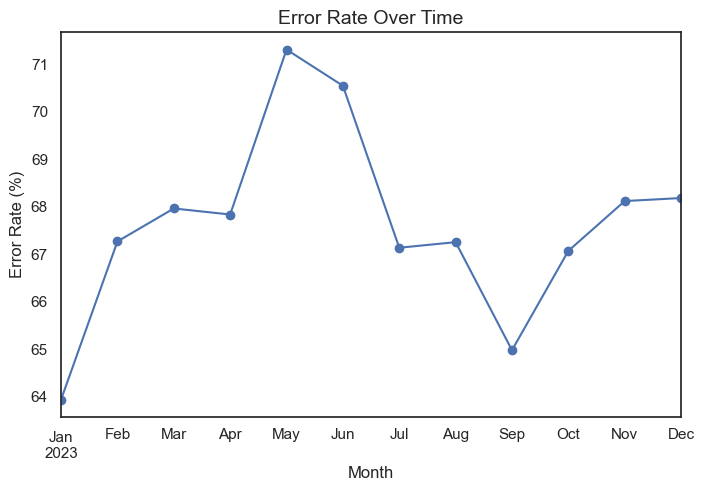

In [73]:
plt.figure()
error_by_month.plot(marker="o")
plt.title("Error Rate Over Time")
plt.xlabel("Month")
plt.ylabel("Error Rate (%)")
plt.grid(False)
plt.show()

In [74]:
recommendations = []

if completeness.mean() < 90:
    recommendations.append("High missing values - run imputation or drop highly incomplete columns.")

if validity.mean() < 90:
    recommendations.append("Placeholder or invalid values detected - re-clean categorical fields.")

if accuracy_score < 90:
    recommendations.append("Cross-field totals do not match - consider using a calculated totals column.")

if unique_score < 95:
    recommendations.append("Duplicate records detected - deduplicate IDs or transactions.")

if consistency_score < 100:
    recommendations.append("Check Transaction ID column for inconsistencies")

recommendations

['High missing values - run imputation or drop highly incomplete columns.',
 'Placeholder or invalid values detected - re-clean categorical fields.',
 'Cross-field totals do not match - consider using a calculated totals column.']